## Importing Libraries

In [1]:
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql import SparkSession
from pyspark.ml import Pipeline
#from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.feature import VectorAssembler, StringIndexer, VectorIndexer, MinMaxScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
spark = SparkSession.builder.master("local[*]").getOrCreate()

23/09/24 20:22:07 WARN Utils: Your hostname, MacBook-Air-de-Mauricio-5.local resolves to a loopback address: 127.0.0.1; using 192.168.100.74 instead (on interface en0)
23/09/24 20:22:07 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/09/24 20:22:08 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data

In [3]:
data = spark.read.csv('train.csv', header = True, inferSchema = True)
data.show(5)

+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|PassengerId|Survived|Pclass|                Name|   Sex| Age|SibSp|Parch|          Ticket|   Fare|Cabin|Embarked|
+-----------+--------+------+--------------------+------+----+-----+-----+----------------+-------+-----+--------+
|          1|       0|     3|Braund, Mr. Owen ...|  male|22.0|    1|    0|       A/5 21171|   7.25| null|       S|
|          2|       1|     1|Cumings, Mrs. Joh...|female|38.0|    1|    0|        PC 17599|71.2833|  C85|       C|
|          3|       1|     3|Heikkinen, Miss. ...|female|26.0|    0|    0|STON/O2. 3101282|  7.925| null|       S|
|          4|       1|     1|Futrelle, Mrs. Ja...|female|35.0|    1|    0|          113803|   53.1| C123|       S|
|          5|       0|     3|Allen, Mr. Willia...|  male|35.0|    0|    0|          373450|   8.05| null|       S|
+-----------+--------+------+--------------------+------+----+-----+-----+------

          Survived    Pclass       Age     SibSp     Parch      Fare
Survived  1.000000 -0.338481 -0.077221 -0.035322  0.081629  0.257307
Pclass   -0.338481  1.000000 -0.369226  0.083081  0.018443 -0.549500
Age      -0.077221 -0.369226  1.000000 -0.308247 -0.189119  0.096067
SibSp    -0.035322  0.083081 -0.308247  1.000000  0.414838  0.159651
Parch     0.081629  0.018443 -0.189119  0.414838  1.000000  0.216225
Fare      0.257307 -0.549500  0.096067  0.159651  0.216225  1.000000


<Axes: >

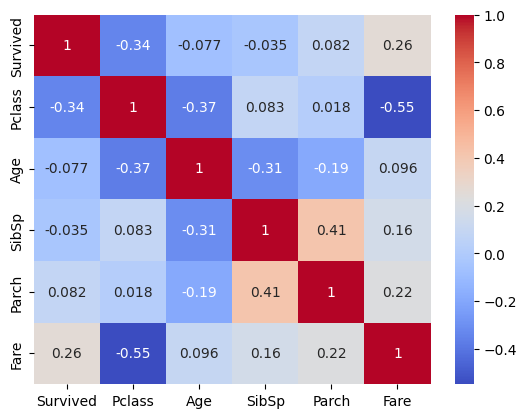

In [4]:
# Displaying correlation matrix for numeric values
df = pd.read_csv('train.csv')
df = df.drop('PassengerId', axis = 1)
# Exclude non-numeric columns
numeric_columns = df.select_dtypes(include='number')
corr_matrix = numeric_columns.corr()

# Display the correlation matrix
print(corr_matrix)
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

## Preparing the data

> ### Splitting the data

We will use 80% of data as training data, and 20% as testing data.

In [5]:
splits = data.randomSplit([0.8,0.2])
train = splits[0]
test = splits[1]
train_rows = train.count()
test_rows = test.count()
print("Training Rows:", train_rows, " Testing Rows:", test_rows)

Training Rows: 708  Testing Rows: 183


> ### Defining our pipeline for five relevant features (Age,Fare,Sex,Pclass,SibSp)

In [6]:
#Importing libraries
from pyspark.ml.feature import Imputer
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import RandomForestClassifier, NaiveBayes

# Create an Imputer transformer to fill null values with median
imputer = Imputer(inputCols=["Age", "Fare"], outputCols=["Age_imputed", "Fare_imputed"], strategy="median")

# Modify the VectorAssembler to include the imputed columns
numVect = VectorAssembler(inputCols=["Fare_imputed", "Age_imputed"], outputCol="numFeatures")

# Define the pipeline stages
strIdx = StringIndexer(inputCol="Sex", outputCol="SexIdx")
catVect = VectorAssembler(inputCols=["Pclass", "SexIdx", "SibSp"], outputCol="catFeatures")
catIdx = VectorIndexer(inputCol=catVect.getOutputCol(), outputCol="idxCatFeatures")
minMax = MinMaxScaler(inputCol=numVect.getOutputCol(), outputCol="normFeatures")
featVect = VectorAssembler(inputCols=["idxCatFeatures", "normFeatures"], outputCol="features")

#Logistic Regression
lr = LogisticRegression(labelCol="Survived", featuresCol="features", maxIter=10, regParam=0.3)
nb = NaiveBayes(labelCol = "Survived",featuresCol="features",smoothing=1.0)
rf = RandomForestClassifier(labelCol = "Survived",featuresCol="features",numTrees=10, maxDepth=5, seed=42)
# Define the pipeline
pipeline_lr = Pipeline(stages=[strIdx, catVect, catIdx, imputer, numVect, minMax, featVect, lr])
pipeline_nb = Pipeline(stages=[strIdx, catVect, catIdx, imputer, numVect, minMax, featVect, nb])
pipeline_rf = Pipeline(stages=[strIdx, catVect, catIdx, imputer, numVect, minMax, featVect, rf])

### Training the model

In [7]:
%%time 
pipline_model_lr = pipeline_lr.fit(train)
pipline_model_nb = pipeline_nb.fit(train)
pipline_model_rf = pipeline_rf.fit(train)

23/09/24 20:22:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS
23/09/24 20:22:14 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.VectorBLAS


CPU times: user 39.8 ms, sys: 22.9 ms, total: 62.7 ms
Wall time: 4.1 s


### Generate label predictions with logistic regression

In [11]:
prediction_lr = pipline_model_lr.transform(test)
print(prediction_lr.columns)

predicted_lr = prediction_lr.select("features","prediction","Survived")
predicted_lr.show(10,truncate = False)


['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'SexIdx', 'catFeatures', 'idxCatFeatures', 'Age_imputed', 'Fare_imputed', 'numFeatures', 'normFeatures', 'features', 'rawPrediction', 'probability', 'prediction']
+------------------------------------------------------+----------+--------+
|features                                              |prediction|Survived|
+------------------------------------------------------+----------+--------+
|(5,[3,4],[0.10122885832000206,0.6732847449107816])    |0.0       |0       |
|[0.0,1.0,0.0,0.051822148727810165,0.7235486303091229] |1.0       |1       |
|[2.0,0.0,1.0,0.06104473451835265,0.4847951746670017]  |0.0       |0       |
|[2.0,1.0,0.0,0.015330377421392339,0.17064589092736868]|1.0       |0       |
|[2.0,1.0,1.0,0.03513366015444757,0.38426740387031916] |0.0       |0       |
|[2.0,1.0,0.0,0.014102260811993537,0.34656948982156316]|0.0       |1       |
|[1.0,0.0,0.0,0.05074862022

### Acuraccy, Recall, F1-Score for logistic regression

In [16]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# Make predictions on the test data
prediction_lr = pipline_model_lr.transform(test)

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
accuracy = evaluator.evaluate(prediction_lr)


# Calculate the F1 score
tp = prediction_lr.filter((prediction_lr.Survived == 1) & (prediction_lr.prediction == 1)).count()
fp = prediction_lr.filter((prediction_lr.Survived == 0) & (prediction_lr.prediction == 1)).count()
fn = prediction_lr.filter((prediction_lr.Survived == 1) & (prediction_lr.prediction == 0)).count()
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)

print("Accuracy for logistic regression:", accuracy)
print("Recall for logistic regression:", recall)
print("F1 score for logistic regression:", f1_score)

Accuracy for logistic regression: 0.7540983606557377
Recall for logistic regression: 0.38333333333333336
F1 score for logistic regression: 0.5054945054945055


### Generate label predictions with Naive bayes

In [17]:
prediction_nb = pipline_model_nb.transform(test)
print(prediction_nb.columns)

predicted_nb = prediction_nb.select("features","prediction","Survived")
predicted_nb.show(10,truncate = False)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'SexIdx', 'catFeatures', 'idxCatFeatures', 'Age_imputed', 'Fare_imputed', 'numFeatures', 'normFeatures', 'features', 'rawPrediction', 'probability', 'prediction']
+------------------------------------------------------+----------+--------+
|features                                              |prediction|Survived|
+------------------------------------------------------+----------+--------+
|(5,[3,4],[0.10122885832000206,0.6732847449107816])    |0.0       |0       |
|[0.0,1.0,0.0,0.051822148727810165,0.7235486303091229] |1.0       |1       |
|[2.0,0.0,1.0,0.06104473451835265,0.4847951746670017]  |0.0       |0       |
|[2.0,1.0,0.0,0.015330377421392339,0.17064589092736868]|1.0       |0       |
|[2.0,1.0,1.0,0.03513366015444757,0.38426740387031916] |1.0       |0       |
|[2.0,1.0,0.0,0.014102260811993537,0.34656948982156316]|1.0       |1       |
|[1.0,0.0,0.0,0.05074862022

### Acuraccy, Recall and F1-Score for Naive Bayes

In [18]:
# Make predictions on the test data
prediction_nb = pipline_model_nb.transform(test)

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
accuracy = evaluator.evaluate(prediction_nb)

# Calculate the F1 score
tp = prediction_nb.filter((prediction_nb.Survived == 1) & (prediction_nb.prediction == 1)).count()
fp = prediction_nb.filter((prediction_nb.Survived == 0) & (prediction_nb.prediction == 1)).count()
fn = prediction_nb.filter((prediction_nb.Survived == 1) & (prediction_nb.prediction == 0)).count()
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)

print("Accuracy for logistic regression:", accuracy)
print("Recall for logistic regression:", recall)
print("F1 score for logistic regression:", f1_score)


Accuracy for logistic regression: 0.7486338797814208
Recall for logistic regression: 0.6166666666666667
F1 score for logistic regression: 0.6166666666666667


### Generate predictions with Random Forest

In [19]:
prediction_rf = pipline_model_rf.transform(test)
print(prediction_rf.columns)

predicted_rf = prediction_rf.select("features","prediction","Survived")
predicted_rf.show(10,truncate = False)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'SexIdx', 'catFeatures', 'idxCatFeatures', 'Age_imputed', 'Fare_imputed', 'numFeatures', 'normFeatures', 'features', 'rawPrediction', 'probability', 'prediction']
+------------------------------------------------------+----------+--------+
|features                                              |prediction|Survived|
+------------------------------------------------------+----------+--------+
|(5,[3,4],[0.10122885832000206,0.6732847449107816])    |0.0       |0       |
|[0.0,1.0,0.0,0.051822148727810165,0.7235486303091229] |1.0       |1       |
|[2.0,0.0,1.0,0.06104473451835265,0.4847951746670017]  |0.0       |0       |
|[2.0,1.0,0.0,0.015330377421392339,0.17064589092736868]|1.0       |0       |
|[2.0,1.0,1.0,0.03513366015444757,0.38426740387031916] |1.0       |0       |
|[2.0,1.0,0.0,0.014102260811993537,0.34656948982156316]|1.0       |1       |
|[1.0,0.0,0.0,0.05074862022

### Acuraccy, Recall and F1 Score for Random Forest

In [23]:


# Make predictions on the test data
prediction_rf = pipline_model_rf.transform(test)

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
accuracy_rf = evaluator.evaluate(prediction_rf)



# Calculate the F1 score
tp = prediction_rf.filter((prediction_rf.Survived == 1) & (prediction_rf.prediction == 1)).count()
fp = prediction_rf.filter((prediction_rf.Survived == 0) & (prediction_rf.prediction == 1)).count()
fn = prediction_rf.filter((prediction_rf.Survived == 1) & (prediction_rf.prediction == 0)).count()
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)

print("Accuracy for logistic regression:", accuracy_rf)
print("Recall for logistic regression:", recall)
print("F1 score for logistic regression:", f1_score)

Accuracy for logistic regression: 0.8306010928961749
Recall for logistic regression: 0.6666666666666666
F1 score for logistic regression: 0.7207207207207207


In [24]:
### Defining our pipeline for 3 features (Age,Fare,Sex)

# Create an Imputer transformer to fill null values with median
imputer = Imputer(inputCols=["Age", "Fare"], outputCols=["Age_imputed", "Fare_imputed"], strategy="median")

# Modify the VectorAssembler to include the imputed columns
numVect = VectorAssembler(inputCols=["Fare_imputed", "Age_imputed"], outputCol="numFeatures")

# Define the pipeline stages
strIdx = StringIndexer(inputCol="Sex", outputCol="SexIdx")
catVect = VectorAssembler(inputCols=["SexIdx"], outputCol="catFeatures")
catIdx = VectorIndexer(inputCol=catVect.getOutputCol(), outputCol="idxCatFeatures")
minMax = MinMaxScaler(inputCol=numVect.getOutputCol(), outputCol="normFeatures")
featVect = VectorAssembler(inputCols=["idxCatFeatures", "normFeatures"], outputCol="features")

#Logistic Regression
lr3 = LogisticRegression(labelCol="Survived", featuresCol="features", maxIter=10, regParam=0.3)
nb3 = NaiveBayes(labelCol = "Survived",featuresCol="features",smoothing=1.0)
rf3 = RandomForestClassifier(labelCol = "Survived",featuresCol="features",numTrees=10, maxDepth=5, seed=42)
# Define the pipeline
pipeline_lr3 = Pipeline(stages=[strIdx, catVect, catIdx, imputer, numVect, minMax, featVect, lr3])
pipeline_nb3 = Pipeline(stages=[strIdx, catVect, catIdx, imputer, numVect, minMax, featVect, nb3])
pipeline_rf3 = Pipeline(stages=[strIdx, catVect, catIdx, imputer, numVect, minMax, featVect, rf3])

In [29]:
%%time 
#Time displayed for 3 features

pipline_model_lr3 = pipeline_lr3.fit(train)
pipline_model_nb3 = pipeline_nb3.fit(train)
pipline_model_rf3 = pipeline_rf3.fit(train)

CPU times: user 33.1 ms, sys: 18.5 ms, total: 51.5 ms
Wall time: 1.49 s


### Logistic Regression with 3 features

In [30]:
prediction_lr3 = pipline_model_lr3.transform(test)
print(prediction_lr3.columns)

predicted_lr3 = prediction_lr3.select("features","prediction","Survived")
predicted_lr3.show(10,truncate = False)


['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'SexIdx', 'catFeatures', 'idxCatFeatures', 'Age_imputed', 'Fare_imputed', 'numFeatures', 'normFeatures', 'features', 'rawPrediction', 'probability', 'prediction']
+----------------------------------------------+----------+--------+
|features                                      |prediction|Survived|
+----------------------------------------------+----------+--------+
|[0.0,0.10122885832000206,0.6732847449107816]  |0.0       |0       |
|[1.0,0.051822148727810165,0.7235486303091229] |1.0       |1       |
|[0.0,0.06104473451835265,0.4847951746670017]  |0.0       |0       |
|[1.0,0.015330377421392339,0.17064589092736868]|1.0       |0       |
|[1.0,0.03513366015444757,0.38426740387031916] |1.0       |0       |
|[1.0,0.014102260811993537,0.34656948982156316]|1.0       |1       |
|[0.0,0.050748620223090936,0.43453128926866047]|0.0       |0       |
|[1.0,0.015671954672893913,0.1

In [32]:
# Make predictions on the test data
prediction_lr3 = pipline_model_lr3.transform(test)

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
accuracy = evaluator.evaluate(prediction_lr3)


# Calculate the F1 score
tp = prediction_lr3.filter((prediction_lr3.Survived == 1) & (prediction_lr3.prediction == 1)).count()
fp = prediction_lr3.filter((prediction_lr3.Survived == 0) & (prediction_lr3.prediction == 1)).count()
fn = prediction_lr3.filter((prediction_lr3.Survived == 1) & (prediction_lr3.prediction == 0)).count()
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)

print("Accuracy for logistic regression with 3 features:", accuracy)
print("Recall for logistic regression with 3 features:", recall)
print("F1 score for logistic regression with 3 features:", f1_score)

Accuracy for logistic regression with 3 features: 0.7486338797814208
Recall for logistic regression with 3 features: 0.6166666666666667
F1 score for logistic regression with 3 features: 0.6166666666666667


### Generate predictions with Naive Bayes and 3 features

In [33]:
prediction_nb3 = pipline_model_nb3.transform(test)
print(prediction_nb3.columns)

predicted_nb3 = prediction_nb3.select("features","prediction","Survived")
predicted_nb3.show(10,truncate = False)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'SexIdx', 'catFeatures', 'idxCatFeatures', 'Age_imputed', 'Fare_imputed', 'numFeatures', 'normFeatures', 'features', 'rawPrediction', 'probability', 'prediction']
+----------------------------------------------+----------+--------+
|features                                      |prediction|Survived|
+----------------------------------------------+----------+--------+
|[0.0,0.10122885832000206,0.6732847449107816]  |0.0       |0       |
|[1.0,0.051822148727810165,0.7235486303091229] |0.0       |1       |
|[0.0,0.06104473451835265,0.4847951746670017]  |0.0       |0       |
|[1.0,0.015330377421392339,0.17064589092736868]|1.0       |0       |
|[1.0,0.03513366015444757,0.38426740387031916] |1.0       |0       |
|[1.0,0.014102260811993537,0.34656948982156316]|1.0       |1       |
|[0.0,0.050748620223090936,0.43453128926866047]|0.0       |0       |
|[1.0,0.015671954672893913,0.1

### Naive Bayes with 3 features

In [35]:
# Make predictions on the test data
prediction_nb3 = pipline_model_nb3.transform(test)

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
accuracy = evaluator.evaluate(prediction_nb3)

# Calculate the F1 score
tp = prediction_nb3.filter((prediction_nb3.Survived == 1) & (prediction_nb3.prediction == 1)).count()
fp = prediction_nb3.filter((prediction_nb3.Survived == 0) & (prediction_nb3.prediction == 1)).count()
fn = prediction_nb3.filter((prediction_nb3.Survived == 1) & (prediction_nb3.prediction == 0)).count()
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)

print("Accuracy for naive bayes:", accuracy)
print("Recall for naive bayes:", recall)
print("F1 score for naive bayes:", f1_score)


Accuracy for naive bayes: 0.726775956284153
Recall for naive bayes: 0.55
F1 score for naive bayes: 0.5689655172413793


### Generate predictions with random forest and 3 features.

In [36]:
prediction_rf3 = pipline_model_rf3.transform(test)
print(prediction_rf3.columns)

predicted_rf3 = prediction_rf3.select("features","prediction","Survived")
predicted_rf3.show(10,truncate = False)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'SexIdx', 'catFeatures', 'idxCatFeatures', 'Age_imputed', 'Fare_imputed', 'numFeatures', 'normFeatures', 'features', 'rawPrediction', 'probability', 'prediction']
+----------------------------------------------+----------+--------+
|features                                      |prediction|Survived|
+----------------------------------------------+----------+--------+
|[0.0,0.10122885832000206,0.6732847449107816]  |0.0       |0       |
|[1.0,0.051822148727810165,0.7235486303091229] |1.0       |1       |
|[0.0,0.06104473451835265,0.4847951746670017]  |0.0       |0       |
|[1.0,0.015330377421392339,0.17064589092736868]|1.0       |0       |
|[1.0,0.03513366015444757,0.38426740387031916] |1.0       |0       |
|[1.0,0.014102260811993537,0.34656948982156316]|1.0       |1       |
|[0.0,0.050748620223090936,0.43453128926866047]|0.0       |0       |
|[1.0,0.015671954672893913,0.1

### Acuraccy, Recall and F1 Score for random forest with 3 features.

In [38]:
# Make predictions on the test data
prediction_rf3 = pipline_model_rf3.transform(test)

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
accuracy_rf3 = evaluator.evaluate(prediction_rf3)



# Calculate the F1 score
tp = prediction_rf3.filter((prediction_rf3.Survived == 1) & (prediction_rf3.prediction == 1)).count()
fp = prediction_rf3.filter((prediction_rf3.Survived == 0) & (prediction_rf3.prediction == 1)).count()
fn = prediction_rf3.filter((prediction_rf3.Survived == 1) & (prediction_rf3.prediction == 0)).count()
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)

print("Accuracy for random forest:", accuracy_rf3)
print("Recall for random forest:", recall)
print("F1 score for random forest:", f1_score)

Accuracy for random forest: 0.7759562841530054
Recall for random forest: 0.6833333333333333
F1 score for random forest: 0.6666666666666666


In [39]:
### Defining our pipeline for 1 feature (Age)

# Create an Imputer transformer to fill null values with median
imputer = Imputer(inputCols=["Age"], outputCols=["Age_imputed"], strategy="median")

# Modify the VectorAssembler to include the imputed columns
numVect = VectorAssembler(inputCols=["Age_imputed"], outputCol="numFeatures")

# Define the pipeline stages
minMax = MinMaxScaler(inputCol=numVect.getOutputCol(), outputCol="normFeatures")
featVect = VectorAssembler(inputCols=["normFeatures"], outputCol="features")

#Logistic Regression
lr1 = LogisticRegression(labelCol="Survived", featuresCol="features", maxIter=10, regParam=0.3)
nb1 = NaiveBayes(labelCol = "Survived",featuresCol="features",smoothing=1.0)
rf1 = RandomForestClassifier(labelCol = "Survived",featuresCol="features",numTrees=10, maxDepth=5, seed=42)
# Define the pipeline
pipeline_lr1 = Pipeline(stages=[imputer, numVect, minMax, featVect, lr1])
pipeline_nb1 = Pipeline(stages=[imputer, numVect, minMax, featVect, nb1])
pipeline_rf1 = Pipeline(stages=[imputer, numVect, minMax, featVect, rf1])

In [41]:
%%time 
#Time displayed for 1 feature

pipline_model_lr1 = pipeline_lr1.fit(train)
pipline_model_nb1 = pipeline_nb1.fit(train)
pipline_model_rf1 = pipeline_rf1.fit(train)

CPU times: user 24.9 ms, sys: 14.6 ms, total: 39.5 ms
Wall time: 1.08 s


### Generating prediction with 1 feature with logistic regression.

In [44]:
prediction_lr1 = pipline_model_lr1.transform(test)
print(prediction_lr1.columns)

predicted_lr1 = prediction_lr1.select("features","prediction","Survived")
predicted_lr1.show(10,truncate = False)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_imputed', 'numFeatures', 'normFeatures', 'features', 'rawPrediction', 'probability', 'prediction']
+---------------------+----------+--------+
|features             |prediction|Survived|
+---------------------+----------+--------+
|[0.6732847449107816] |0.0       |0       |
|[0.7235486303091229] |0.0       |1       |
|[0.4847951746670017] |0.0       |0       |
|[0.17064589092736868]|0.0       |0       |
|[0.38426740387031916]|0.0       |0       |
|[0.34656948982156316]|0.0       |1       |
|[0.43453128926866047]|0.0       |0       |
|[0.18321186227695402]|0.0       |1       |
|[0.09525006282985675]|0.0       |0       |
|[0.34656948982156316]|0.0       |1       |
+---------------------+----------+--------+
only showing top 10 rows



In [45]:
# Make predictions on the test data
prediction_lr1 = pipline_model_lr1.transform(test)

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
accuracy = evaluator.evaluate(prediction_lr1)


# Calculate the F1 score
tp = prediction_lr1.filter((prediction_lr1.Survived == 1) & (prediction_lr1.prediction == 1)).count()
fp = prediction_lr1.filter((prediction_lr1.Survived == 0) & (prediction_lr1.prediction == 1)).count()
fn = prediction_lr1.filter((prediction_lr1.Survived == 1) & (prediction_lr1.prediction == 0)).count()
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)

print("Accuracy for logistic regression with 1 feature:", accuracy)
print("Recall for logistic regression with 1 feature:", recall)
print("F1 score for logistic regression with 1 feature:", f1_score)

Accuracy for logistic regression with 1 feature: 0.6721311475409836
Recall for logistic regression with 1 feature: 0.0
F1 score for logistic regression with 1 feature: 0.0


### Generating prediction with 1 feature with naive bayes.

In [ ]:
prediction_nb1 = pipline_model_nb1.transform(test)
print(prediction_nb1.columns)

predicted_nb1 = prediction_nb1.select("features","prediction","Survived")
predicted_nb1.show(10,truncate = False)

In [46]:
# Make predictions on the test data
prediction_nb1 = pipline_model_nb1.transform(test)

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
accuracy = evaluator.evaluate(prediction_nb1)

# Calculate the F1 score
tp = prediction_nb1.filter((prediction_nb1.Survived == 1) & (prediction_nb1.prediction == 1)).count()
fp = prediction_nb1.filter((prediction_nb1.Survived == 0) & (prediction_nb1.prediction == 1)).count()
fn = prediction_nb1.filter((prediction_nb1.Survived == 1) & (prediction_nb1.prediction == 0)).count()
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)

print("Accuracy for naive bayes with 1 feature:", accuracy)
print("Recall for naive bayes with 1 feature:", recall)
print("F1 score for naive bayes with 1 feature:", f1_score)

Accuracy for naive bayes with 1 feature: 0.6721311475409836
Recall for naive bayes with 1 feature: 0.0
F1 score for naive bayes with 1 feature: 0.0


### Generating prediction with 1 feature with random forest

In [47]:
prediction_rf1 = pipline_model_rf1.transform(test)
print(prediction_rf1.columns)

predicted_rf1 = prediction_rf1.select("features","prediction","Survived")
predicted_rf1.show(10,truncate = False)

['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked', 'Age_imputed', 'numFeatures', 'normFeatures', 'features', 'rawPrediction', 'probability', 'prediction']
+---------------------+----------+--------+
|features             |prediction|Survived|
+---------------------+----------+--------+
|[0.6732847449107816] |0.0       |0       |
|[0.7235486303091229] |0.0       |1       |
|[0.4847951746670017] |0.0       |0       |
|[0.17064589092736868]|1.0       |0       |
|[0.38426740387031916]|0.0       |0       |
|[0.34656948982156316]|0.0       |1       |
|[0.43453128926866047]|1.0       |0       |
|[0.18321186227695402]|1.0       |1       |
|[0.09525006282985675]|1.0       |0       |
|[0.34656948982156316]|0.0       |1       |
+---------------------+----------+--------+
only showing top 10 rows



In [ ]:
# Make predictions on the test data
prediction_rf1 = pipline_model_rf1.transform(test)

# Create a MulticlassClassificationEvaluator object
evaluator = MulticlassClassificationEvaluator(labelCol="Survived", predictionCol="prediction", metricName="accuracy")

# Calculate the accuracy
accuracy_rf1 = evaluator.evaluate(prediction_rf1)



# Calculate the F1 score
tp = prediction_rf1.filter((prediction_rf1.Survived == 1) & (prediction_rf1.prediction == 1)).count()
fp = prediction_rf1.filter((prediction_rf1.Survived == 0) & (prediction_rf1.prediction == 1)).count()
fn = prediction_rf1.filter((prediction_rf1.Survived == 1) & (prediction_rf1.prediction == 0)).count()
recall = tp / (tp + fn)
f1_score = 2 * tp / (2 * tp + fp + fn)

print("Accuracy for random forest with 1 feature:", accuracy_rf1)
print("Recall for random forest with 1 feature:", recall)
print("F1 score for random forest:", f1_score)